# Audio Transformations step-by-step

In this tutorial we will consider 5 popular audio transformations for data augmentation: adding noise, changing speed, changing pitch, time masking, cut & splice.

In [229]:
import numpy as np
import librosa as lr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import IPython
import scipy.io

# Auxiliary functions

In [197]:
matplotlib.rc('font', size=12)

In [198]:
def plot_signal(signal, title, ax=None, xlabel='time,s'):

    if ax==None:
        fig, ax = plt.subplots(figsize=(4,3))

    ax.plot(signal)
    ticks_loc = ax.get_xticks()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(np.round(ticks_loc/sr,2))
    ax.set_xlabel(xlabel)
    ax.set_title(title);
    
    return ax

# Signal

For illustration purposes, will use the sample *common_voice_en_100040* from the [Mozilla Common Voice dataset](https://commonvoice.mozilla.org/). This is the sentence *The fire had been extinguished*.

In [199]:
signal, sr = lr.load('./transformed/common_voice_en_100040.wav', res_type='kaiser_fast') #load signal

In [200]:
#remove silence  at the beginning and at the end 

start_time = 0.7
stop_time = 3.7

signal = signal[int(start_time*sr):int(stop_time*sr)]

In [201]:
# play the sentence

IPython.display.Audio(signal, rate=sr)

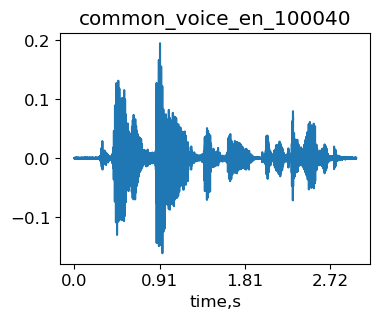

In [202]:
#visualize signal 

plot_signal(signal, 'common_voice_en_100040');

# Adding noise



Adding noise is the simplest audio augmentation. The amount of noise is characterised by the signal-to-noise ratio (SNR) - the ratio between maximal signal amplitude and standard deviation of noise. We will generate several noise levels, defined with SNR, and see how they change the signal.

In [203]:
SNRs = (5,10,100,1000) #Signal-to-noise ratio: max amplitude over noise std

noisy_signal = {}

for snr in SNRs:
    
    noise_std = max(abs(signal))/snr #get noise std
    noise =  noise_std*np.random.randn(len(signal),) #generate noise with given std
    
    noisy_signal[snr] = signal+noise

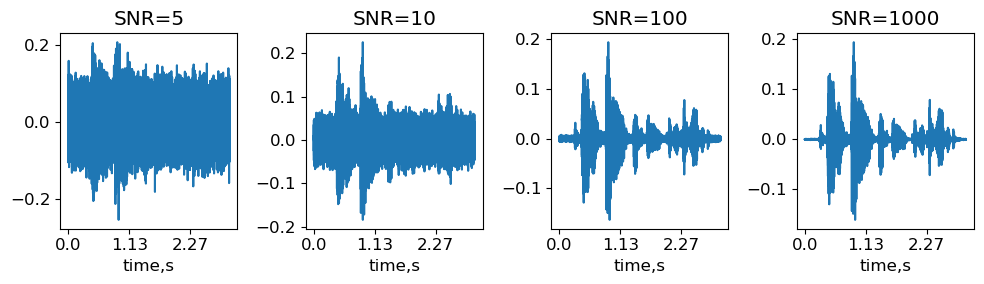

In [205]:
fig, axes = plt.subplots(1,4,figsize=(10,3))

for snr, ax in zip(SNRs, axes.flatten()):
    
    plot_signal(noisy_signal[snr], f'SNR={snr}',ax);
    
fig.tight_layout()

In [206]:
IPython.display.display(IPython.display.Audio(noisy_signal[5], rate=sr))
IPython.display.display(IPython.display.Audio(noisy_signal[1000], rate=sr))

In [235]:
#scipy.io.wavfile.write('./transformed/snr_5.wav',sr, noisy_signal[5])
#scipy.io.wavfile.write('./transformed/snr_1000.wav',sr, noisy_signal[1000])

So, at SNR=5 only the strongest signal intervals are visible over the noise, whereas at SNR=1000 the noise is barely noticeable. The standard deviation of noise is a hyperparameter and depends on a particular application. Sometimes it makes sense to add noise only to a part of the dataset.

# Changing speed

The simplest way to change the speed is just to pretend that the signal has a different sample rate. However, this will also change the pitch (how low/high it sounds). Increasing the sampling rate will make the voice sound higher. To illustrate this, we shall "increase" the sampling rate for our example by 1.5:

In [83]:
IPython.display.Audio(signal, rate=sr*1.5)

Changing the speed without affecting the pitch is more challenging. One needs to use the [Phase Vocoder](https://en.wikipedia.org/wiki/Phase_vocoder)(PV) algorithm. In brief, the input signal is first split into overlapping frames. Then, the spectrum within each frame is computed by applying Fast Fourier Transformation (FFT). The playing speed is then modifyed by resynthetizing frames at a different rate. Since the frequency content of each frame is not affected, the pitch remains the same. The PV interpolates between the frames and uses the phase information to make the process smooth.

For our experiments, we will use the PV implementation from [here](https://github.com/gaganbahga/time_stretch).

In [109]:
def time_stretch(signal, factor, nfft=2048):

    '''
    Phase Vocoder time stretching in frequency domain, adopted from
    https://github.com/gaganbahga/time_stretch
    '''

    stft = lr.core.stft(signal, n_fft=nfft).transpose()
    stft_rows = stft.shape[0]
    stft_cols = stft.shape[1]

    times = np.arange(0, stft.shape[0], factor)
    hop = nfft/4
    phase_adv = (2 * np.pi * hop * np.arange(0, stft_cols))/ nfft
    stft = np.concatenate((stft, np.zeros((1, stft_cols))), axis=0)

    indices = np.floor(times).astype(np.int)
    alpha = np.expand_dims(times - np.floor(times), axis=1)
    mag = (1. - alpha) * np.absolute(stft[indices, :]) + alpha * np.absolute(stft[indices + 1, :])
    dphi = np.angle(stft[indices + 1, :]) - np.angle(stft[indices, :]) - phase_adv
    dphi = dphi - 2 * np.pi * np.floor(dphi/(2 * np.pi))
    phase_adv_acc = np.matmul(np.expand_dims(np.arange(len(times) + 1),axis=1), np.expand_dims(phase_adv, axis=0))
    phase = np.concatenate( (np.zeros((1, stft_cols)), np.cumsum(dphi, axis=0)), axis=0) + phase_adv_acc
    phase += np.angle(stft[0, :])
    stft_new = mag * np.exp(phase[:-1,:]*1j)
    return lr.core.istft(stft_new.transpose())

In [122]:
stretching_factor = 1.3

signal_stretched = time_stretch(signal, stretching_factor) 

/scratch/tmp/l_vilov/ipykernel_2642876/3028213397.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.floor(times).astype(np.int)


In [117]:
IPython.display.Audio(signal_stretched, rate=sr)

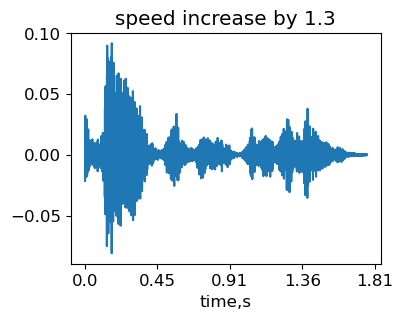

In [121]:
plot_signal(signal_stretched, f'speed increase by {speed_factor}');

So, the duration of the signal decreased since we increased the speed. However, one can hear that the pitch has not changed. Note that when the stretching factor is substantial, the phase interpolation between frames might not work well, which results in echo artefacts. 

In [234]:
#scipy.io.wavfile.write('./transformed/faster_speed.wav',sr, signal_stretched)

# Changing pitch

To alter the pitch without affecting the speed, we can use the same Phase Vocoder time stretch, but pretend that the signal has a different sampling rate such that the total duration of the signal is the same.

In [125]:
IPython.display.Audio(signal_stretched, rate=sr/stretching_factor)

In [233]:
#scipy.io.wavfile.write('./transformed/lower_pitch.wav',int(sr/stretching_factor), signal_stretched)

The two following transformations (time mask and cut & splice) were initially proposed in the frequency domain ([Park et al. 2019](https://www.isca-speech.org/archive_v0/Interspeech_2019/pdfs/2680.pdf)). The idea was to save time on FFT by using precomputed spectra for audio augmentations. For simplicity, we will demonstrate how these transformations work in the time domain. The described operations can be easily transferred to the frequency domain by replacing the time axis with frame index.

# Time masking

The idea of time masking is to cover up a random region in the signal. The neural network has then less chances to learn signal-specific temporal variations that are not generalizable.

In [219]:
max_mask_length = 0.3 #maximum mask duration, proportion of signal length

L = len(signal)

mask_length = int(L*np.random.rand()*max_mask_length) #randomly choose mask length
mask_start = int((L-mask_length)*np.random.rand()) #randomly choose mask position

masked_signal = signal.copy()
masked_signal[mask_start:mask_start+mask_length] = 0

In [220]:
IPython.display.Audio(masked_signal, rate=sr)

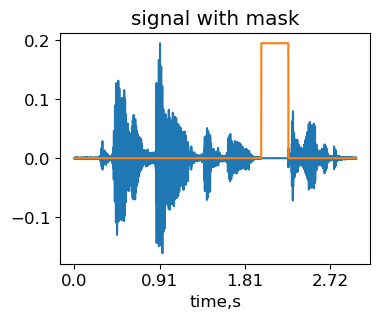

In [221]:
ax = plot_signal(masked_signal, f'signal with mask')

signal_countour = np.zeros((L,))
signal_countour[mask_start:mask_start+mask_length] = max(masked_signal)
    
ax.plot(signal_countour); #indicate where the mask is applied

In [231]:
#scipy.io.wavfile.write('./transformed/masked_signal.wav',sr, masked_signal)

# Cut & splice

The idea is to replace a randomly selected region of the signal with an equally long random fragment from another signal of the same class. The implementation is almost the same as for time masking, except that a piece of another signal is inserted at the place rather than a mask.

In [222]:
other_signal, sr = lr.load('./common_voice_en_100038.wav', res_type='kaiser_fast') #load signal

max_fragment_length = 0.3 #maximum fragment duration, proportion of signal length

L = min(len(signal), len(other_signal))

mask_length = int(L*np.random.rand()*max_fragment_length) #randomly choose mask length
mask_start = int((L-mask_length)*np.random.rand()) #randomly choose mask position

synth_signal = signal.copy()
synth_signal[mask_start:mask_start+mask_length] = other_signal[mask_start:mask_start+mask_length]

In [225]:
IPython.display.Audio(synth_signal, rate=sr)

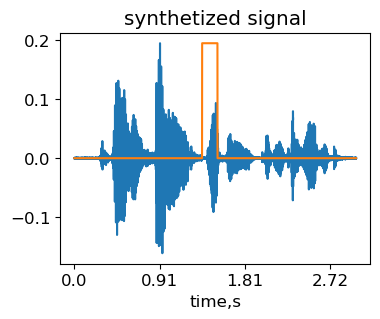

In [224]:
ax = plot_signal(synth_signal, f'synthetized signal')

signal_countour = np.zeros((L,))
signal_countour[mask_start:mask_start+mask_length] = max(synth_signal)
    
ax.plot(signal_countour); #indicate where the fragment is inserted

In [230]:
#scipy.io.wavfile.write('./transformed/synth_signal.wav',sr, synth_signal)